### General instructions

This assignment is associated with the privacy module, and is mandatory for the subject. You have just over two weeks to submit the assignment, during which you can attend seminars that go at the usual times go get help.

**FORMAT**: Jupyter notebook  
**DEADLINE**: Friday 26th March, 23:59

Parts of code taken from: https://machinelearningmastery.com/imbalanced-classification-with-the-adult-income-dataset/

# 1. Private model selection

You are given 5 classifiers, and you will implement a private algorithm for answering the question “which classifier does best on the test data”? To report a private answer we return sample from a distribution over models using the 
[Exponential Mechanism](https://en.wikipedia.org/wiki/Exponential_mechanism_(differential_privacy)).


In [4]:
# Imports
import numpy as np
import random
from numpy import mean
from numpy import std
from pandas import read_csv
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

## The Adult Dataset

The adult dataset has been retrieved from the UCI machine learning repository.

Source: https://archive.ics.uci.edu/ml/datasets/adult

This dataset consists of information about Americans who have been categorised by whether they ear less than 50K per year in 1994.

In [5]:
def load_dataset(full_path):
    # load the dataset as a numpy array
    dataframe = read_csv(full_path, header=None, na_values='?')
    # drop rows with missing
    dataframe = dataframe.dropna()
    # split into inputs and outputs
    last_ix = len(dataframe.columns) - 1
    X, y = dataframe.drop(last_ix, axis=1), dataframe[last_ix]
    # select categorical and numerical features
    cat_ix = X.select_dtypes(include=['object', 'bool']).columns
    num_ix = X.select_dtypes(include=['int64', 'float64']).columns
    # label encode the target variable to have the classes 0 and 1
    y = LabelEncoder().fit_transform(y)
    return X.values, y, cat_ix, num_ix

In [6]:
# define the location of the dataset
full_path = 'adult-all.csv'
# load the dataset
X, y, cat_ix, num_ix = load_dataset(full_path)
# summarize the loaded dataset
print("Dimensions of dataset:  X -", X.shape, " y -", y.shape)
#print(X[0:10])
#print(y[0:10])

Dimensions of dataset:  X - (45222, 14)  y - (45222,)


In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.222, shuffle=True, random_state = 42)
print("Train size:", len(X_train))
print("Validation size:", len(X_val))

Train size: 35182
Validation size: 10040


## Models to evaluate

Five models are trained on the adult dataset:
1. Decision tree classifier (CART)
2. Support vector machine (SVM)
3. Bagging classifier (BAG)
4. Random forest classifier (RF)
5. Gradient boosting classifier (GBM)

Their training accuraracies are shown below.

>DT   Accurracy: 1.000
>SVC   Accurracy: 0.841
>BAG   Accurracy: 1.000
>RF   Accurracy: 1.000
>GBM   Accurracy: 0.865


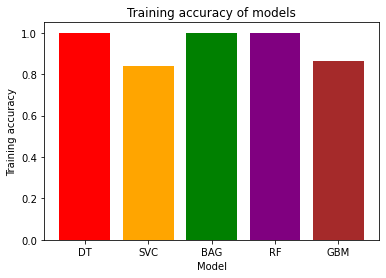

In [8]:
# evaluate a model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# define models to test
def get_models():
    models, names = list(), list()
    # CART
    models.append(DecisionTreeClassifier())
    names.append('DT')
    # SVM
    models.append(SVC(gamma='scale'))
    names.append('SVC')
    # Bagging
    models.append(BaggingClassifier(n_estimators=100))
    names.append('BAG')
    # RF
    models.append(RandomForestClassifier(max_depth = 102, n_estimators = 100, random_state = 42))
    names.append('RF')
    # GBM
    models.append(GradientBoostingClassifier(n_estimators=100))
    names.append('GBM')
    return models, names

# define steps
steps = [('c',OneHotEncoder(handle_unknown='ignore'),cat_ix), ('n',MinMaxScaler(),num_ix)]
# one hot encode categorical, normalize numerical
ct = ColumnTransformer(steps) # used in pipeline
models, names = get_models()
results = list()

# keep track of model names
model_names_dict = {}
for i in range(len(models)):
    model = models[i]
    model_names_dict[type(model).__name__] = names[i]

# evaluate each model
for i in range(len(models)):
    # wrap the model i a pipeline
    pipeline = Pipeline(steps=[('t',ct),('m',models[i])])
    # train the model and store results
    pipeline.fit(X_train, y_train)
    trained_model = pipeline
    prediction = trained_model.predict(X_train)
    accurracy = accuracy_score(prediction, y_train)
    results.append(accurracy)
    # summarize performance
    print('>%s   Accurracy: %.3f' % (names[i], accurracy))
# plot the results
# Histogram
names = names
values = results
fig = plt.figure()
plt.bar(names, values, color=['red', 'orange', 'green', 'purple', 'brown', 'blue'])
plt.ylabel('Training accuracy')
plt.xlabel('Model')
plt.title("Training accuracy of models");

## Which model performs best on the validation data?

Now it's your turn. In the cells below answer the question "Which model performs best on the test data?"

**Assumptions:** The validation data are considered private; the train data are not needed because the classifiers are pre-trained. This means you only need to concern yourself with ``X_val`` and ``y_val``, and do not need to make any modifications to the trained models. (The models are trained if you have run all the cells above)

To answer this questions we have split the task into four points

#### A: Attack model

How could somebody attack model selection? That is, how could somebody learn something new about someone in the validation data based on the model selected? Remember that the adversary might already know something about the data. You can also assume that the attacker can pick classifiers freely.

If the chosen classifier is deterministic, for example; no random weight initialization. And you already know some of the data, I think you could extrapolate more of the data
by seeing how adding new data affects the model, and other deterministic models used in model selection.


#### B: Score function
What score function should we use to compare models on the test set? Briefly justify your answer and state the sensitivity of this score.

I used accuracy as a score function, this is because I don't really have much indication to not use accuracy.
y = 1 is about 1/4 so a model always guessing 0 would only achieve an accuracy of 75%.
The sensitivity of accuracy is 1 since 0 is min and 1 is max.

In [9]:
def get_score(X, y, model):
    """
    :param X: test data containing the features of the datapoints
    :param y: test data contianing the corresponding labels to the datapoints in X
    :param model: pre-trained model for which you are to evaluate using your chosen scoring function.
    
    :return score: how well the model performed according to the scoring function on your test data
    """
    model = Pipeline(steps=[('t',ct),('m',model)]) # wrap model in pipeline. Remember, this model has been trained
    pred = model.predict(X)
    score = accuracy_score(pred, y)
    return score

#### C: Exponential Mechanism
Implement the Exponential Mechanism using the score you implemented above. Note that the exponential_mechanism function takes as an argument [sensitivity](https://en.wikipedia.org/wiki/Differential_privacy#Sensitivity) of the score function $s$ and [$\epsilon$](https://en.wikipedia.org/wiki/Differential_privacy#%CE%B5-differential_privacy). Justify your choice for $s$.

In [10]:
def exponential_mechanism(X, y, models, score_function, sensitivity, epsilon):
    scores = np.empty(len(models))
    exp = np.empty(len(models))
    probabilities = np.empty(len(models))
    exp_sum = 0
    for i, model in enumerate(models):
        scores[i] = score_function(X, y, model)
        exp[i] = np.power(np.e, (epsilon*scores[i])/2*sensitivity)
        exp_sum += exp[i]
    for i in range(len(exp)):
        probabilities[i] = exp[i]/exp_sum
    return probabilities

#Checking if using accuracy is justified
filter = y == 1
print(len(y), len(y[filter]))

45222 11208


#### D: Parameter values
Once your implementation is working, run ``exponential_mechanism`` with $\epsilon \in \{0.01, 0.1, 1, 10\}$ and $n \in \{100, 1000, 1000\}$, where $n$ is the size of the validation set. Select a model with ``exponential_mechanism`` many times for each $(\epsilon, n)$ pair, and plot the frequencies for each model. In other words, there should be 12 plots all together, one for each $(\epsilon, n)$ pair. Look over the plots and comment on any trends you notice.
Which model would you choose had you used a "standard" model selection procedure?

Had I used standard model selection I would have picked the Gradient Boosting Classifier.

DT   0.8120517928286852
SVC   0.8349601593625497
BAG   0.8566733067729083
RF   0.8540836653386454
GBM   0.8641434262948208
Sensitivity:  0.052091633466135545


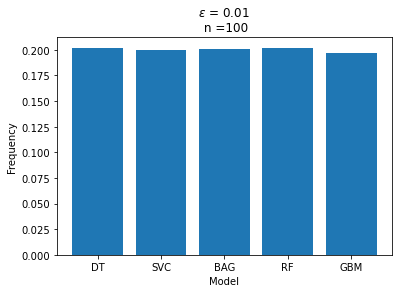

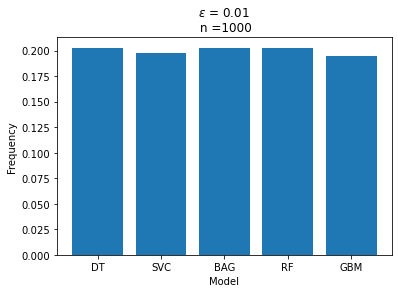

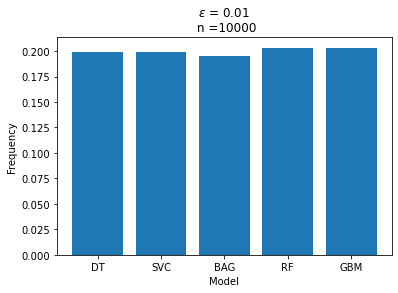

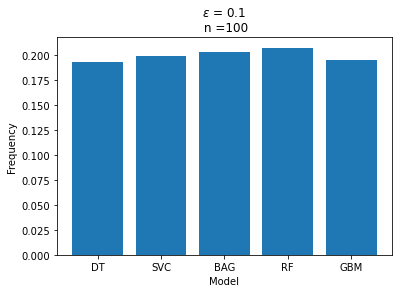

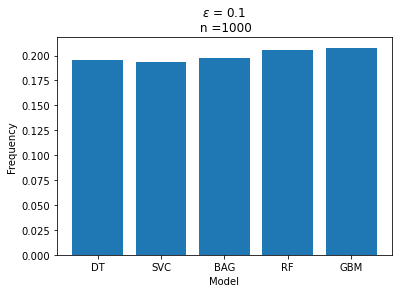

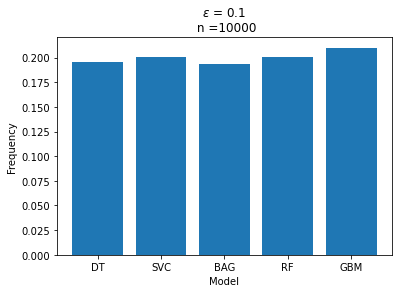

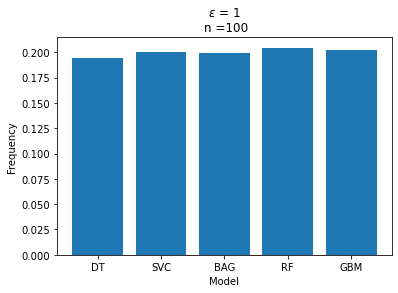

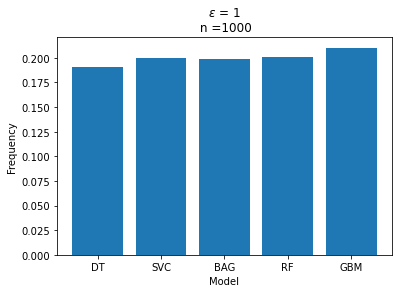

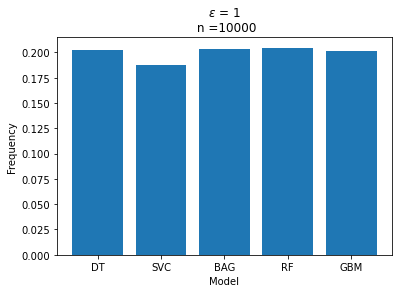

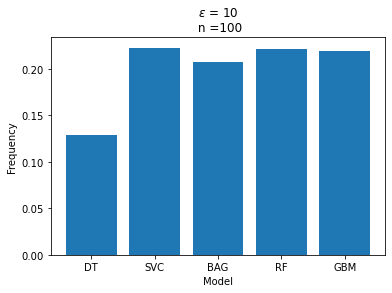

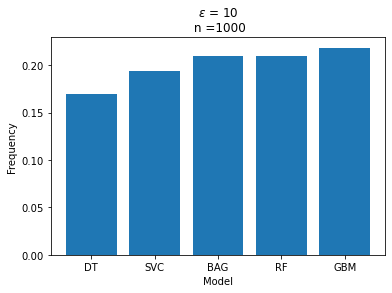

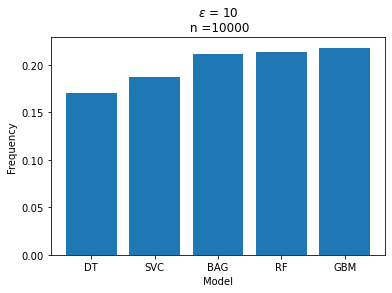

In [17]:
#Checking standard model selection procedure
min = 1.0
max = 0.0
for i in range(len(models)):
    score = get_score(X_val, y_val, models[i])
    print(names[i] + "   " + str(score))
    if score >  max:
        max = score
    if score < min:
        min = score

sensitivity = max - min
print("Sensitivity: ", sensitivity)

iterations = 10_000
for epsilon in [0.01, 0.1, 1, 10]:
    for n in [100, 1000, 10000]:
        probabilities = exponential_mechanism(X_val[:n],y_val[:n],models, get_score, 1, epsilon)
        model_picked_n = np.empty(len(probabilities))
        for i in range(iterations):
            picked = np.random.uniform()
            j = 0
            sum_probabilities = probabilities[j]
            while sum_probabilities < picked:
                j += 1
                sum_probabilities += probabilities[j]
            model_picked_n[j] += 1
        model_picked_n = model_picked_n/iterations
        plt.bar(names,model_picked_n)
        plt.ylabel("Frequency")
        plt.xlabel("Model")
        plt.title("$\epsilon$ = " + str(epsilon) + "\n n =" + str(n))
        plt.show()

 # TODO run the implementation with different parameter values, and plot the results


# 2. Differentially private age estimation

We want to estimate average age for different nationalities in our data. We are going to use the same data set as in the previous task. To protect privacy of individuals in the data, we use differential privacy.

#### A: Laplace mechanism

Average age is a numerical value and thus we can use the Laplace mechanism. Implement the Laplace mechanism.

In [12]:
def laplace_mechanism(X, arg, nationality,epsilon):
    filter = X[:,13] == nationality
    data = X[filter]
    #print(data)
    delta_f = np.max(data[:,arg])-np.min(data[:,arg])
    #print(delta_f)
    mean = np.mean(data[:,arg])
    b = delta_f/epsilon
    # prob_dens_func = np.power(1/(2*b), -np.abs(mean)/b)
    draw = np.random.laplace(0, b)
    return mean+draw, mean




#### B:  Age estimation

Use the Laplace mechanism to estimate average age for different nationalities (Column 11). Remember to estimate sensitivity.

Use the validation data from above. Make predictions for the average age (Column 0) of the following nationalities: Cambodia, Canada, Mexico, and United States. Compare results that you get with $\epsilon = 0.1, 1, 10$.

What can you say about the utility of the private estimates for each nationality? (Hint: Compare to the true value.)

I Find that you need to have a very high epsilon in order to actually have some utility in the returned value,
even with an epsilon of 10 there is often more than a 50year span between the outliers, so if someone was unlucky on their
query and got an outlier, the data would be useless. There is also some difference in variation for each nationality with each epsilon.
For example Cambodia has a much smaller span in maximum and minimum returned value compared to the other countries, this is indicative of a smaller span in the data.

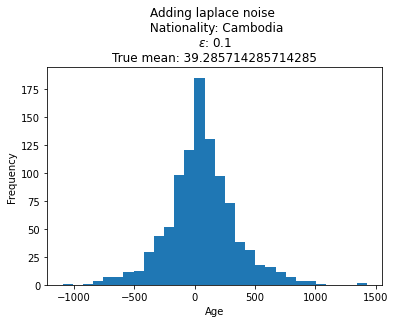

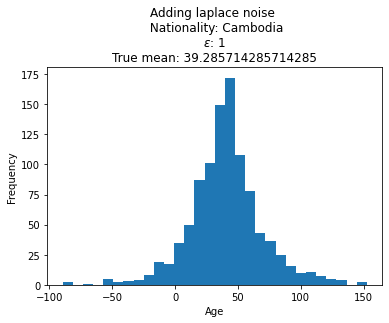

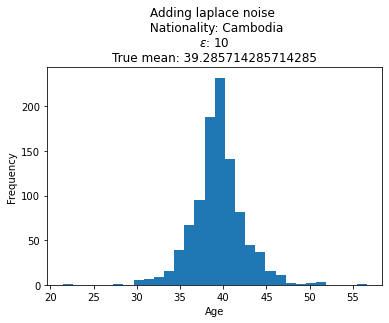

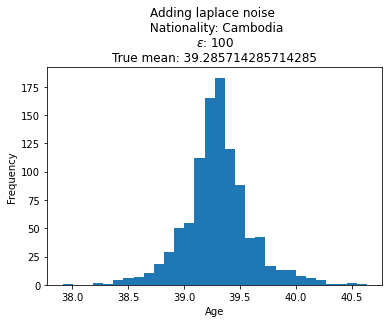

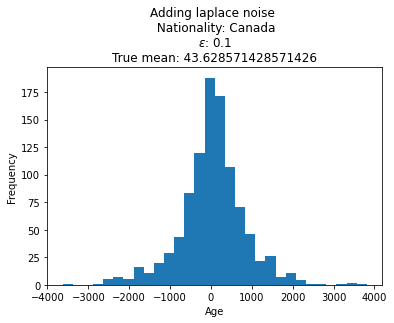

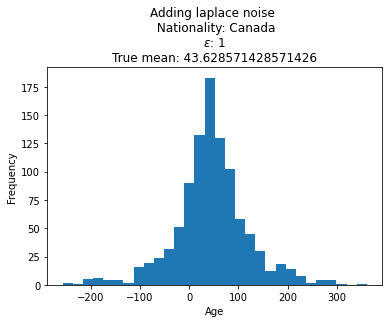

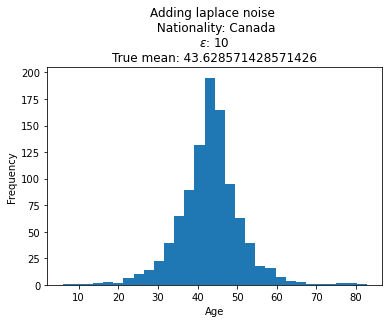

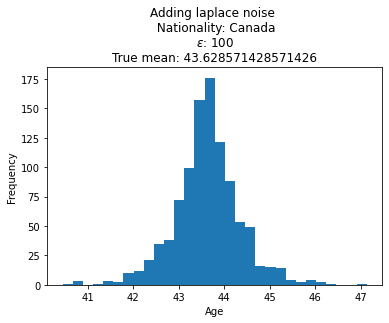

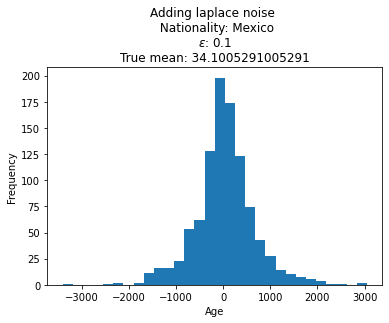

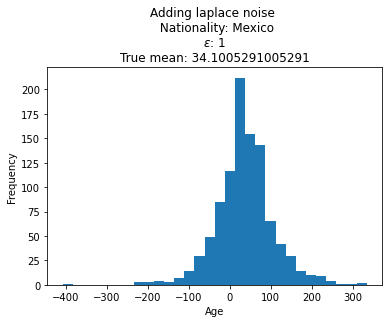

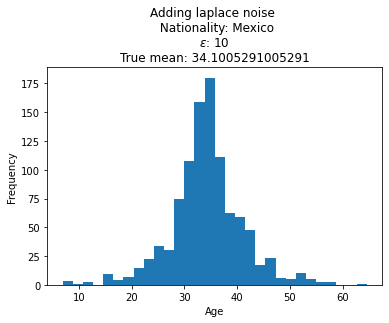

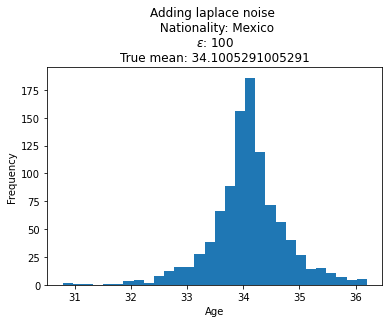

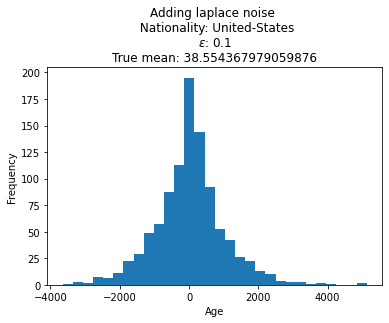

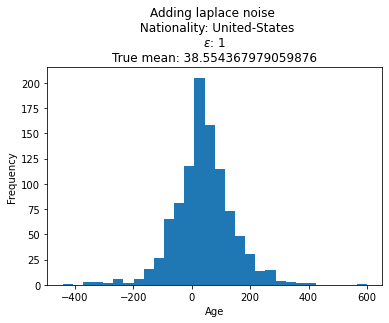

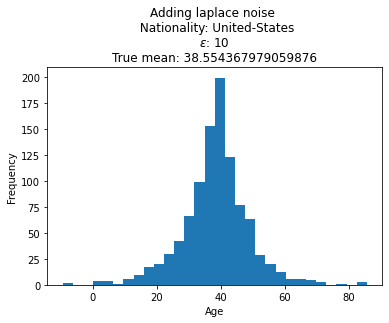

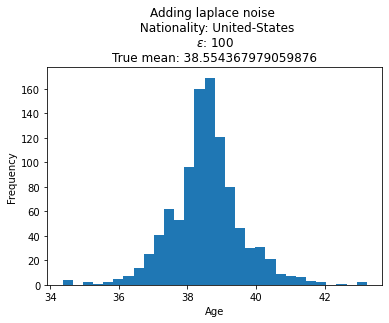

In [13]:
draws = 1000
for nationality in ["Cambodia", "Canada", "Mexico", "United-States"]:
    for epsilon in [0.1, 1, 10, 100]:
        results = np.empty(draws)
        for i in range(draws):
            result, mean = laplace_mechanism(X_val,0, nationality, epsilon)
            results[i] = result
        plt.hist(results, 30)
        plt.title("Adding laplace noise \n Nationality: " + nationality + "\n$\epsilon$: " + str(epsilon)
                  + "\nTrue mean: " + str(mean))
        plt.xlabel("Age")
        plt.ylabel("Frequency")
        plt.show()

#### C: Estimation of average capital gains.

Now instead of average age, we are interested in average capital gains for each nationality. Use the same nationalities and $\epsilon$s as above.

What can you say about the utility of the private estimates for each nationality? How do these differ from the previous case? Can you explain why?

Hint: You can estimate sensitivity by looking the data

When it comes to capital gains the span seems to be much greater than age, thus a higher epsilon will be required to
consistently return values not straying too far from the mean.
We again see a smaller span in capital gains for cambodia compared to the other countries.

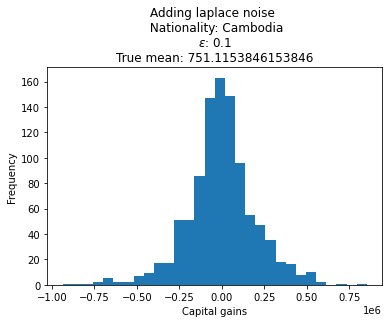

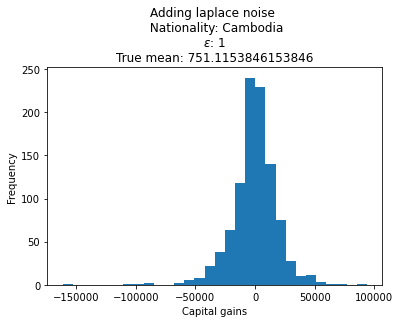

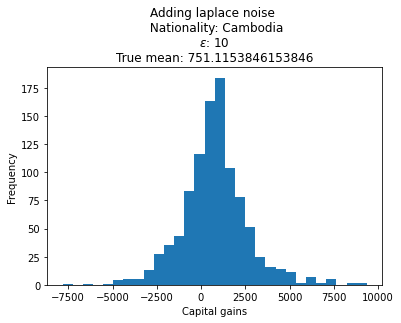

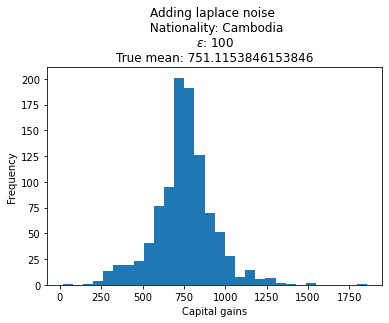

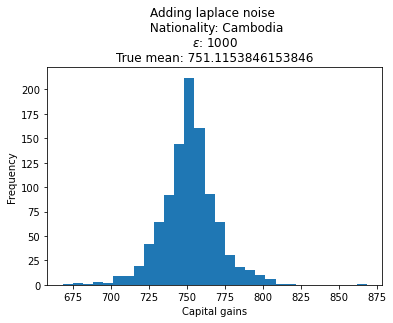

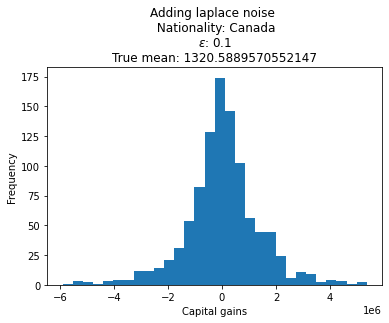

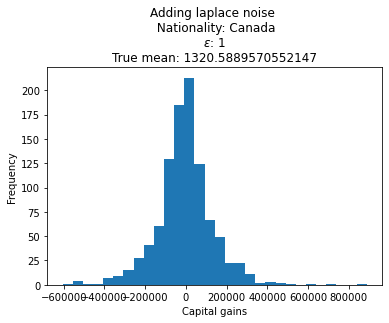

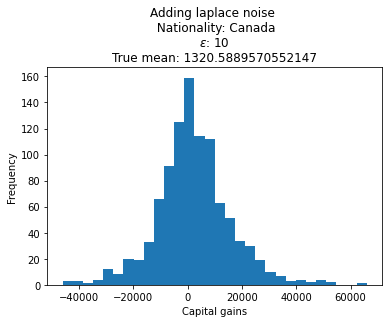

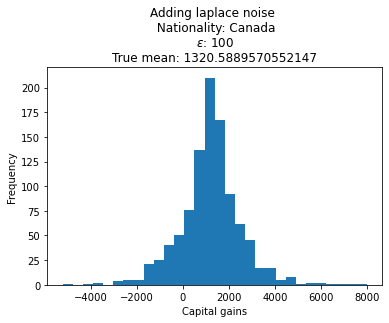

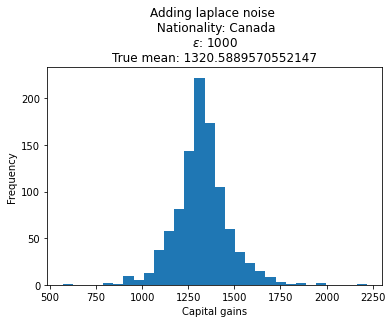

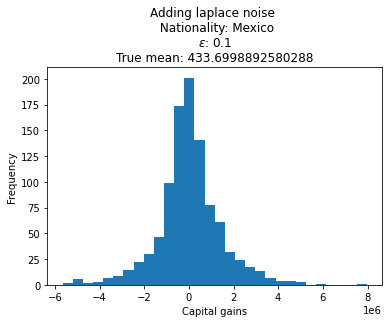

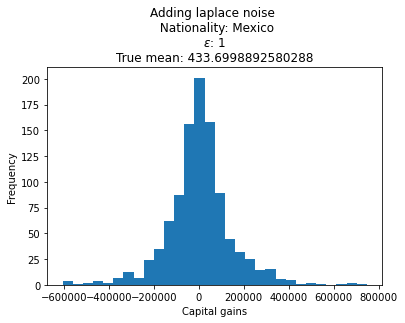

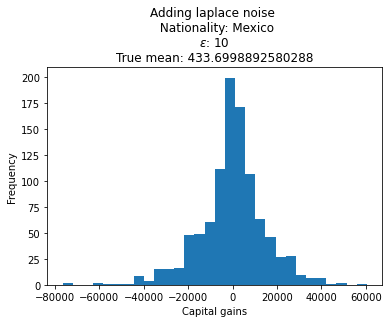

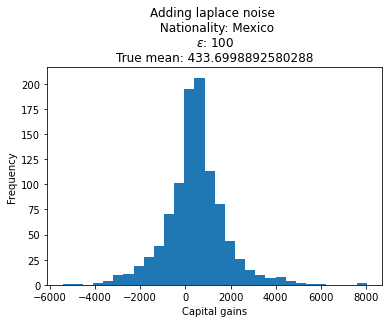

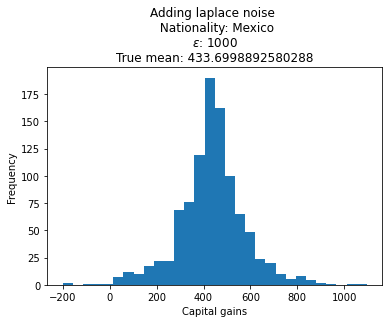

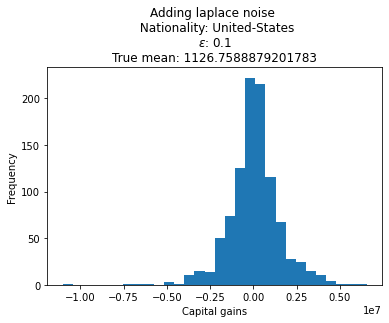

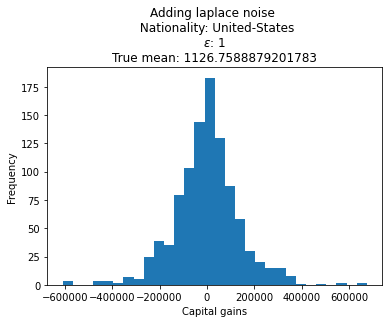

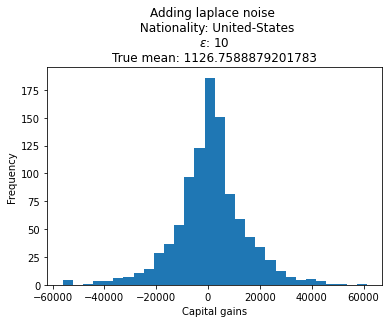

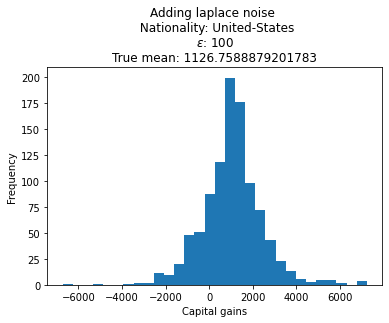

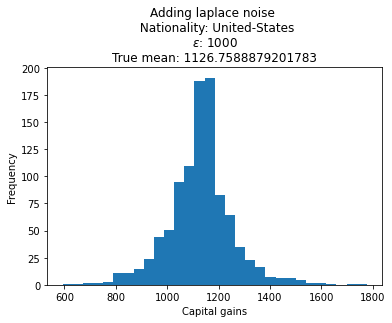

In [14]:
draws = 1000
for nationality in ["Cambodia", "Canada", "Mexico", "United-States"]:
    for epsilon in [0.1, 1, 10, 100, 1000]:
        results = np.empty(draws)
        for i in range(draws):
            result, mean = laplace_mechanism(X,10, nationality, epsilon)
            results[i] = result
        plt.hist(results, 30)
        plt.title("Adding laplace noise \n Nationality: " + nationality + "\n$\epsilon$: " + str(epsilon)
                  + "\nTrue mean: " + str(mean))
        plt.xlabel("Capital gains")
        plt.ylabel("Frequency")
        plt.show()
